In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf.join(abundances, ['sample type', 'sample'])

In [6]:
prf = prf[(prf['sample type'] != 'single-strain') &
          (prf['sample type'] != 'sterile-water-blank') &
          (prf['sample type'] != 'mock-community') &
          (prf['sample type'] != 'plant-surface')]
prf = prf[(prf['class weights'] == 'bespoke70') |
          (prf['class weights'] == 'uniform70') |
          (prf['class weights'] == 'background') |
          (prf['class weights'] == 'plant-corpus')]
prf = prf[prf['method'] == 'weighted']
level7 = prf[prf['level'] == 7]

In [7]:
grouped = level7.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'], ddof=len(x))
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [8]:
old_labels = 'plant-corpus', 'background', 'uniform70', 'bespoke70'
new_labels = 'Wrong', 'Average', 'Uniform', 'Bespoke'
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new

In [9]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Wrong', 'Average', 'Uniform', 'Bespoke'
))
cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")
ggplot(data=figure1, aes(x=sample.type, y=mean, fill=class.weights)) +
  geom_bar(stat="identity", position=position_dodge()) +
  geom_errorbar(aes(ymin=lower, ymax=upper), position=position_dodge()) +
  coord_flip(ylim=c(0.65,0.95)) + 
  theme_bw() +
  theme(legend.position="bottom", 
        legend.direction="horizontal") +
  labs(x='EMPO3 Habitat', y='F-measure') +
  scale_fill_manual(values=cbPalette) +
  guides(fill=guide_legend(title="Taxonomic Weights", nrow=2, byrow=TRUE))
ggsave(file="figure1.png", width=5, height=10, dpi=300)

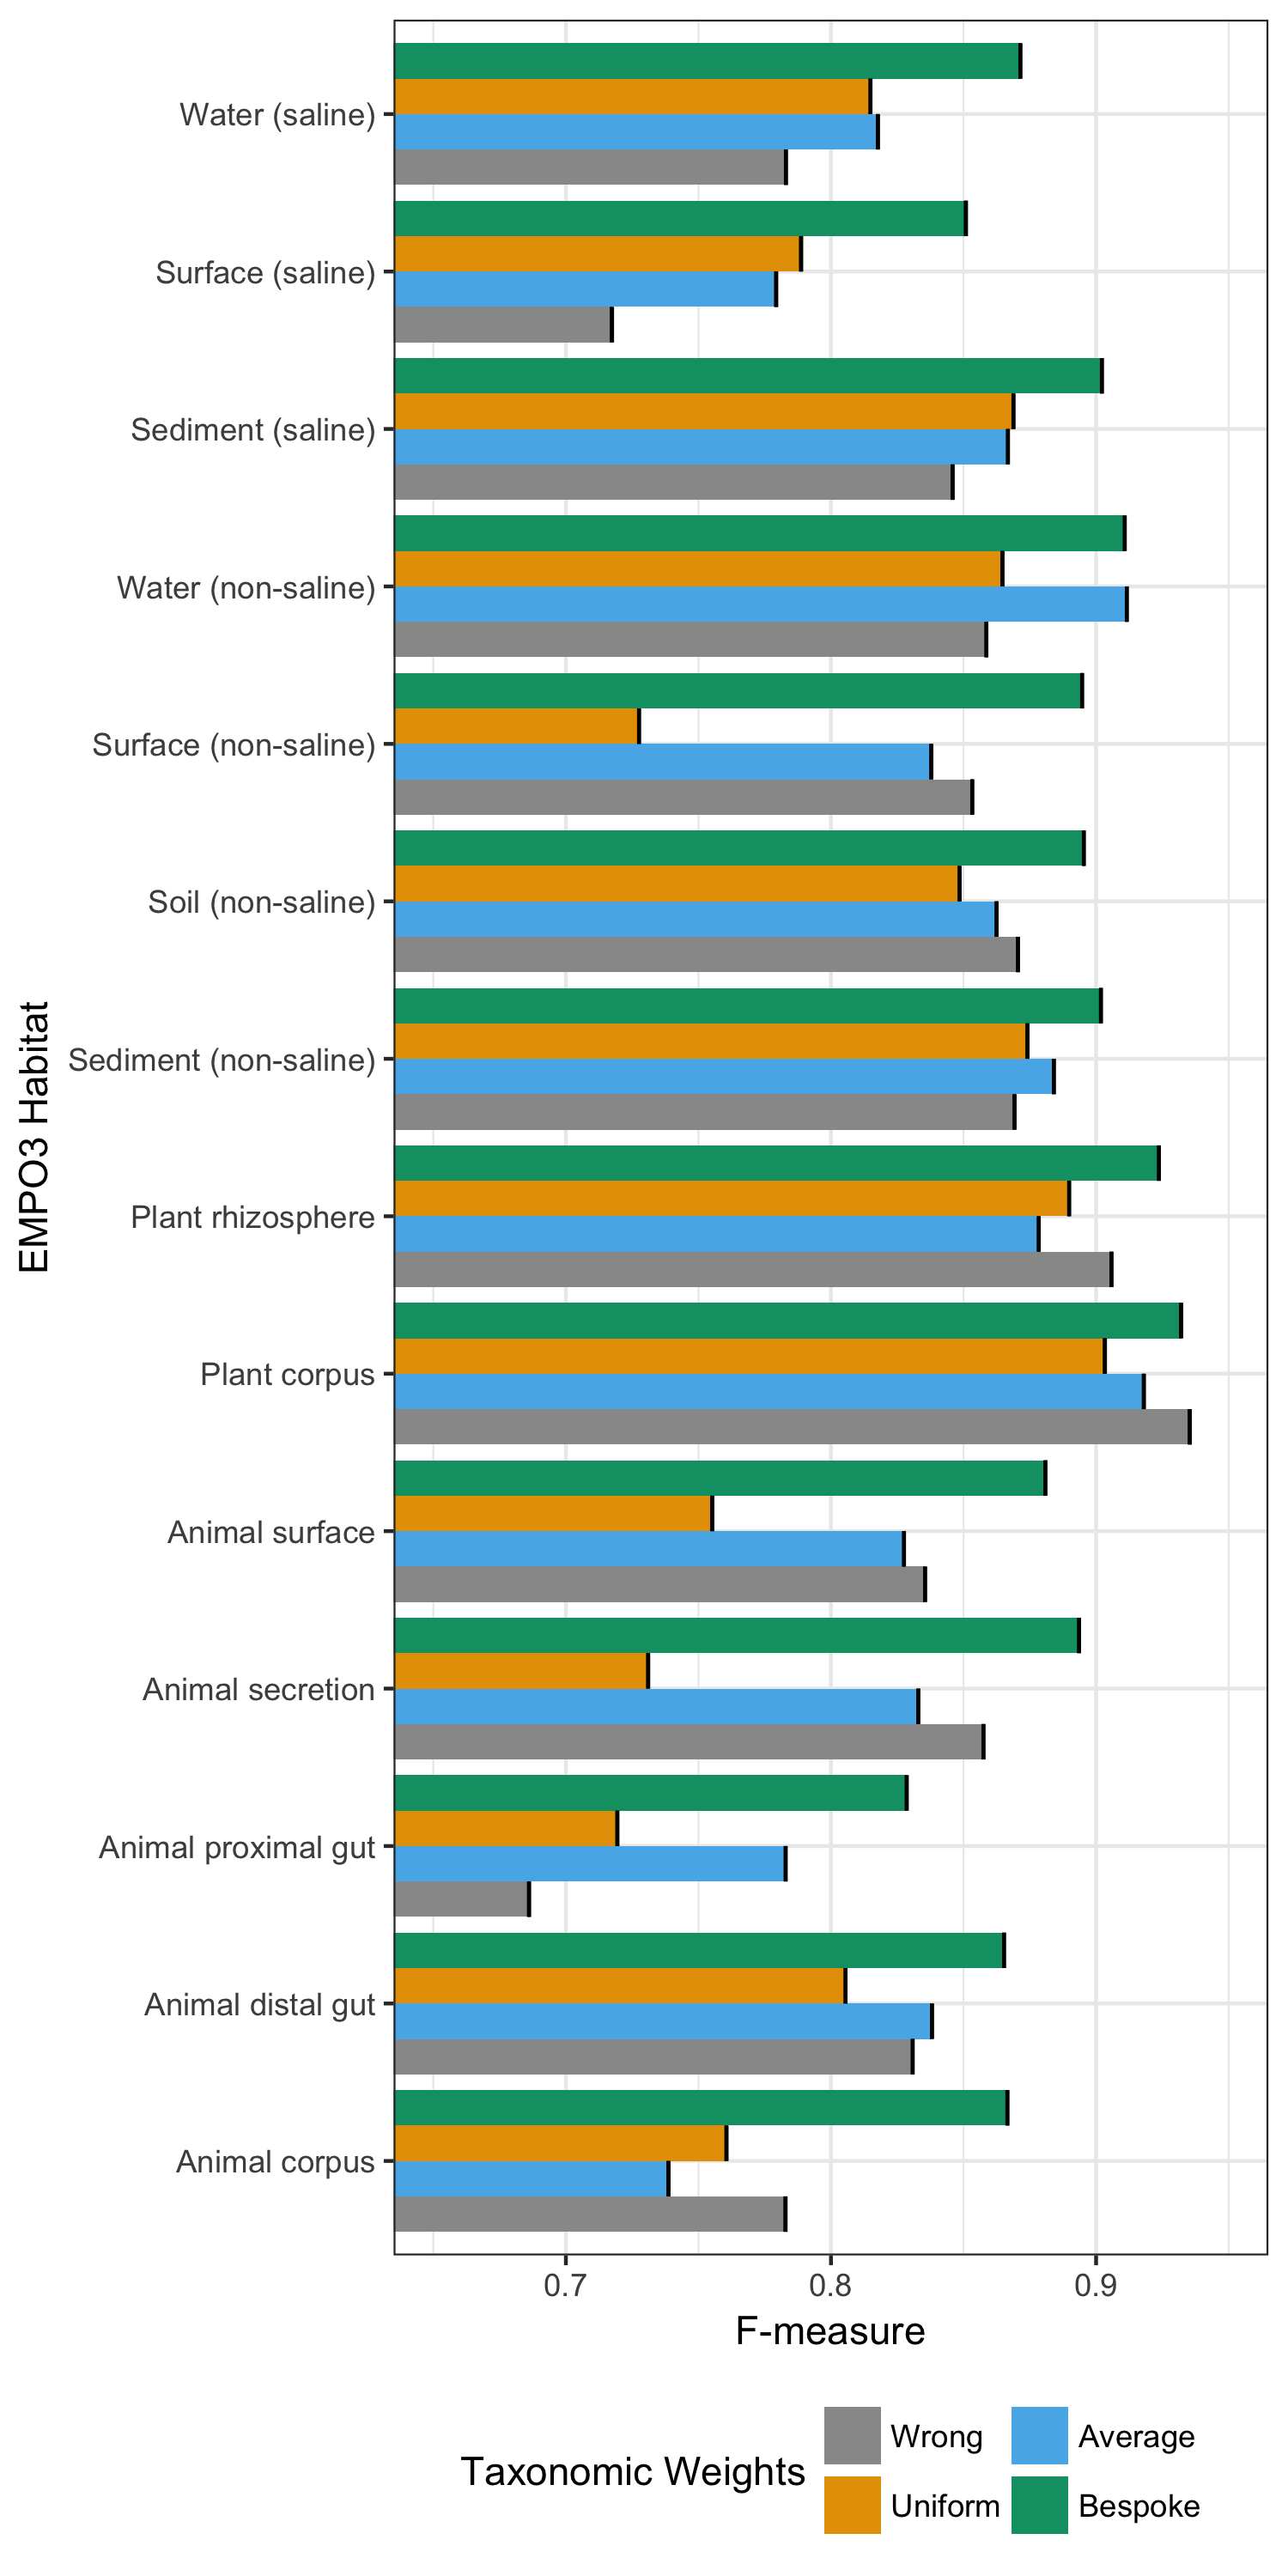

In [10]:
Image("figure1.png")

In [11]:
max(figure1['upper'] - figure1['lower'])

0.00017073176285653524

In [15]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.828570480287922 0.9320860452790769
0.7194145279746841 0.9033168887563143


In [19]:
len(set(level7['sample']))

21513

In [25]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204